In [14]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

#FTRAIN = '../../Data/training.csv'
#FTEST = '../../Data/test.csv'
FTRAIN = 'training.csv'
FTEST = 'test.csv'

def Load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {0}; X.min == {1:.3f}; X.max == {2:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {0}; y.min == {1:.3f}; y.max == {2:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

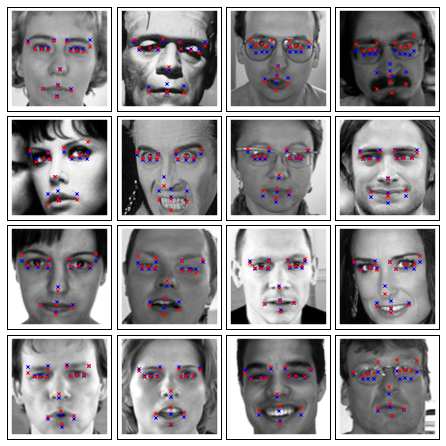

In [16]:
%matplotlib inline

import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import time
import matplotlib
from matplotlib import pyplot

#from Data import load

srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(name, shape):
    '''Initializes the network weights with small random values'''
    return theano.shared(floatX(np.random.randn(*shape) * 0.01), name)

def rectify(X):
    return T.maximum(X, 0.)

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0., 'acc')
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def sgd(cost, w, lr=0.01):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * lr])
    return updates

def dropout(X, p=0.):
    '''
    Randomly set an element of X to zero with a probability of p.
    
    '''
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h, w_o, p_drop_input, p_drop_hidden):
    '''
    X = Input data
    w_h = input-to-hidden layer weights
    w_o = hidden-layer-to-output weights
    p_drop_input = probability of dropping an input data point
    p_drop_hidden = probability of dropping a
    '''
    X = dropout(X, p_drop_input)

    h = rectify(T.dot(X, w_h))
    
    h = dropout(h, p_drop_hidden)

    py_x = T.dot(h, w_o)
    return h, py_x

#allX, allY = Load.load()
allX, allY = Load()

trX = allX[:1800]
trY = allY[:1800]
deX = allX[1800:]
deY = allY[1800:]

X = T.fmatrix("X")
Y = T.fmatrix("Y")

w_h = init_weights("w_h", (9216, 100))
w_o = init_weights("w_o", (100, 30))

noise_h, noise_py_x = model(X, w_h, w_o, 0.2, 0.5)
h, py_x = model(X, w_h, w_o, 0., 0.)

cost = ((Y - noise_py_x)**2).mean()

params = [w_h, w_o]
updates = sgd(cost, params, lr=.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=py_x, allow_input_downcast=True)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
            cost = train(trX[start:end], trY[start:end])
        pdeY = predict(deX)
        cost_de = ((deY - pdeY)**2).mean()
        print '%d) precision=%.4f, Traning cost=%.4f, DE cost: %.4f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)

gradientDescentStochastic(10) 

#
# Let's see how the predictions come out
#
def plot_sample(x, y, y_pred, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y_pred[1::2] * 48 + 48, marker='x', s=10)
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', c='r', s=10)

y_pred = predict(deX)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(deX[i], deY[i], y_pred[i], ax)

pyplot.show()

In [56]:
#help(dropout)
#dropout(T.tensor([3,3,3,3,3]),p=.2)
((1,1),(2,2))*srng.binomial((2,2), p=.1, dtype=theano.config.floatX)

Elemwise{mul,no_inplace}.0

In [41]:
bork = srng.binomial(size=(1,1),nstreams=1)

In [65]:
bork = np.array([1.,2.,3.,4.])
bork /= 0.8
print bork

[ 1.25  2.5   3.75  5.  ]
